# ChatBot (Data Preparation)

In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    
    from google.colab import drive
    drive.mount('/content/drive')
    
    ! git clone https://github.com/tikendraw/chatbot-with-attention.git 
    os.chdir('chatbot-with-attention') 
    print(os.getcwd())

    ! pip install tensorflow==2.11 -q
    ! pip install tensorflow-text -q

In [2]:
import zipfile
import seaborn as sns
import random, os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention
import tensorflow_text as tf_text
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

print('GPU Avaliable: ', gpu:=len(tf.config.list_physical_devices('GPU')))
if gpu:
    pass



2023-03-02 16:17:18.190747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 16:17:20.013531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-03-02 16:17:20.013690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-03-02 16:17:20.013700: W tensorflow/compiler/tf2ten

GPU Avaliable:  1


2023-03-02 16:17:21.725913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 16:17:21.769344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-02 16:17:21.770235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
data = pd.read_csv('./dataset.csv',sep = '\t',encoding='latin1', names = ['col1','col2'])
data1 = pd.read_csv('./human_chat_dataset/human_dataset.csv',encoding='latin1')

In [4]:
# show the data
data.head()

,col1,col2
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
3,You're asking me out. That's so cute. What's ...,Forget it.
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.


In [5]:
data1.columns

Index(['Unnamed: 0', 'col1', 'col2'], dtype='object')

In [6]:
data1.drop('Unnamed: 0', axis = 1, inplace  =True)
data1.head()

,col1,col2
0,Hi!,What is your favorite holiday?
1,one where I get to meet lots of different peo...,What was the most number of people you have e...
2,Hard to keep a count. Maybe 25.,Which holiday was that?
3,I think it was Australia,Do you still talk to the people you met?
4,Not really. The interactions are usually shor...,"Yea, me too. I feel like God often puts stran..."


In [7]:
data1.isnull().sum()

col1    0
col2    0
dtype: int64

In [8]:
# check for null values
data.isnull().sum()

col1    0
col2    0
dtype: int64

In [9]:
data = pd.concat([data1,data], axis = 0)
data.shape

(222012, 2)

In [10]:
# senetence lenght of conversations
data['col1_length'] = data.col1.apply(lambda x: len(str(x).split()))
data['col2_length'] = data.col2.apply(lambda x: len(str(x).split()))

In [25]:
data.head()

,col1,col2,col1_length,col2_length
0,Hi!,What is your favorite holiday?,1,5
1,one where I get to meet lots of different peo...,What was the most number of people you have e...,10,14
2,Hard to keep a count. Maybe 25.,Which holiday was that?,7,4
3,I think it was Australia,Do you still talk to the people you met?,5,9
4,Not really. The interactions are usually shor...,"Yea, me too. I feel like God often puts stran...",22,44


In [26]:

def distplot_axis(x:np.array, axis:list=list(range(95,100)), percent:int = 99,where_text:int = 5000,xlim:list=None, ylim:list=None, **kwargs):
    # plt.figure(figsize = (15,7))
    plt.grid()

    plt.hist(x , bins = 50, **kwargs)
    # Title Word Count distribution
    try:
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    except:
        pass

    plt.xlabel('word length')
    plt.ylabel('Count')
    for i in axis:
        plt.axvline(x = np.percentile(x, i), color = 'b', label = 'axvline - full height')
        # random_pixel = 
        try:
            plt.text(np.percentile(x, i),where_text,f'{i} percent',rotation=90)
        except:
            pass

    plt.title(f'Text Word Count distribution: {np.percentile(x, percent)} words cover {percent}% of text data')



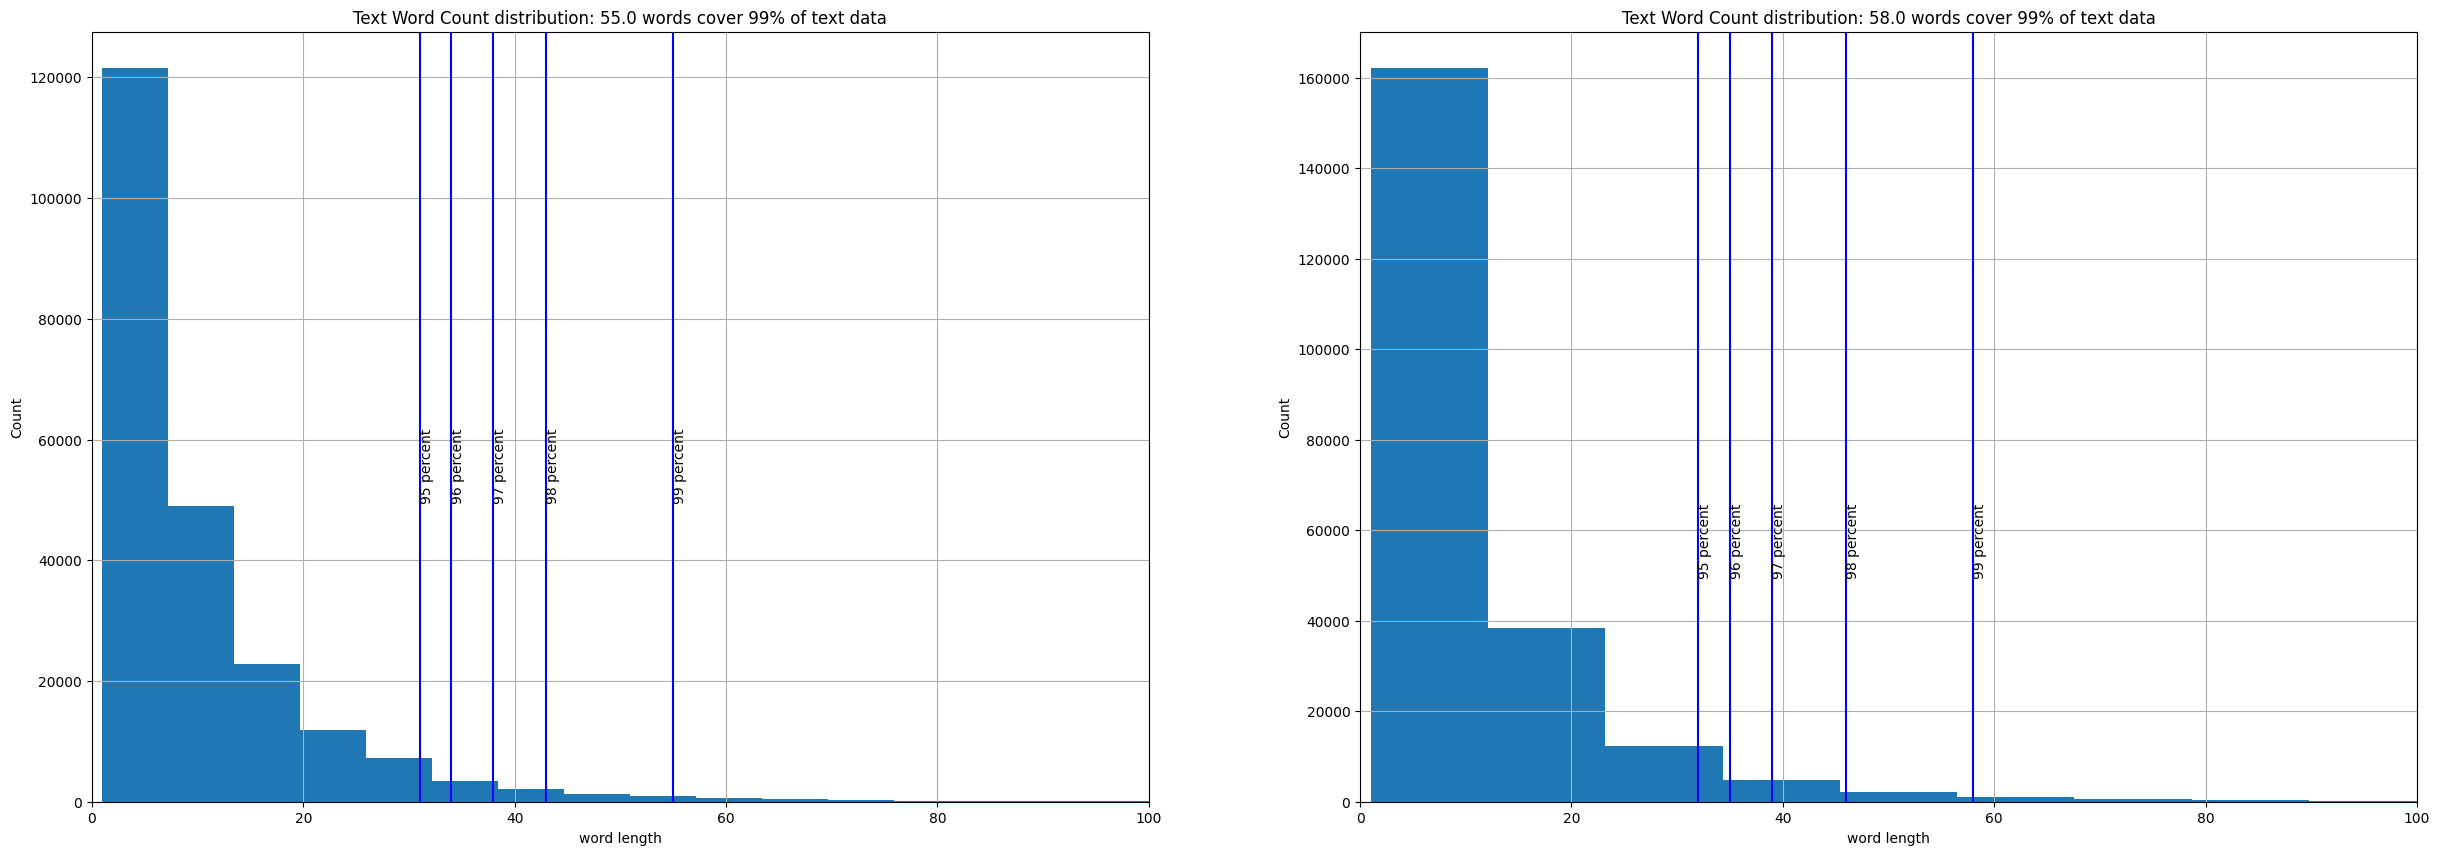

In [27]:
plt.figure(figsize = (30,10))

plt.subplot(1,2,1)
distplot_axis(data.col1_length,where_text = 50000, xlim=[0,100])


plt.subplot(1,2,2)
distplot_axis(data.col2_length,where_text = 50000, xlim=[0,100])

In [28]:
MAX_OUTPUT_LENGTH = 200
BATCH_SIZE = 32
UNITS = 64
EMBEDDING_DIMS = 50

# Splitting Data

In [29]:
# Here we be using whole data as training data, we want out model to know every word that exist. and test it with a fraction of it. This is not a regresssion or classification.
# we will ultimately test with our words

# We are trying to give it as much of the data we can

In [21]:
ss1 = data.iloc[:,[1]]
ss0 = data.iloc[:,[0]]



In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(ss0,ss1, train_size=.05 , test_size=.005, random_state= 44)

In [23]:
print(f'{xtrain.shape=}')
print(f'{ytrain.shape=}')
print(f'{xtest.shape=}')
print(f'{ytest.shape=}')

xtrain.shape=(11100, 1)
ytrain.shape=(11100, 1)
xtest.shape=(1111, 1)
ytest.shape=(1111, 1)


In [25]:
train_data = tf.data.Dataset.from_tensor_slices((ss0,ss1))
test_data = tf.data.Dataset.from_tensor_slices((xtest, ytest))

# Text Vectorization

In [33]:
# preprocessing text
def tf_lower_and_split_punct_en(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text



In [34]:
# vectorization
vectorizer = TextVectorization(output_sequence_length=MAX_OUTPUT_LENGTH, standardize=tf_lower_and_split_punct_en)

In [35]:
for i,j in train_data.take(1):
    print(i)
    print(j)

tf.Tensor(b' Hi!', shape=(), dtype=string)
tf.Tensor(b' What is your favorite holiday?', shape=(), dtype=string)


In [36]:
all_words_here = pd.concat([data['col1'],data['col2']], axis = 0)
all_words_here

0                                                       Hi!
1          one where I get to meet lots of different peo...
2                           Hard to keep a count. Maybe 25.
3                                  I think it was Australia
4          Not really. The interactions are usually shor...
                                ...                        
221277    I'm to take the Sikali with the main column to...
221278    Lord Chelmsford seems to want me to stay back ...
221279    I think Chelmsford wants a good man on the bor...
221280    And I assure you, you do not In fact I'd be ob...
221281    So far only their scouts. But we have had repo...
Length: 444024, dtype: object

In [37]:
# %%timeit
# 20.2 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 21* 7 == 2 MIN 27 sec
vectorizer.adapt(all_words_here)

In [38]:
print('vocab size', vectorizer.vocabulary_size())


vocab size 60156


In [39]:
print('20 common words:',vectorizer.get_vocabulary()[:20])

20 common words: ['', '[UNK]', '.', '[START]', '[END]', ',', 'you', '?', 'i', 'the', 'to', 'a', 'it', 'and', 'of', 'that', '!', 'in', 'what', 'me']


## Reading Glove

In [40]:

zi = zipfile.ZipFile('./embedding/glove.6B.50d.zip')
zi.extractall('./embedding/')
zi.close()

In [41]:
embeddings_index = {}
with open('./embedding/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print("Glove Loded!")


Glove Loded!


In [42]:
len(embeddings_index)

400000

In [43]:
word_dict = {word:i for i, word in enumerate(vectorizer.get_vocabulary())}

In [44]:
len(word_dict)

60156

In [45]:



# """"""
# # Create matrix that holds words that occour together
# """"""

embedding_dimention = 50
def embedding_matrix_creater(embedding_dimention, word_index):
    embedding_matrix = np.zeros((len(word_index), embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


embedding_matrix = embedding_matrix_creater(50, word_index=word_dict)    

VOCAB_SIZE = vectorizer.vocabulary_size()

embedding = Embedding(VOCAB_SIZE, 
                  50, 
                  
                  input_length=13,
                  trainable=True)

embedding.build((None,))
embedding.set_weights([embedding_matrix])



In [46]:
embedding_matrix.shape

(60156, 50)

In [47]:
type(embedding_matrix)

numpy.ndarray

In [48]:
# saving embedding_matrix for further use
np.save('./embedding/embedding_matrix.npy',embedding_matrix, allow_pickle=True)

In [49]:
vectorizer.vocabulary_size()

60156

In [50]:
len(word_dict)

60156

In [51]:
embedding_matrix.shape

(60156, 50)

### saving vectorizer
https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow


In [52]:
# Pickle the config and weights

os.makedirs('components', exist_ok=True)
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("./components/vectorizer.pkl", "wb"))


### Loading saved vectorizer

In [53]:
# Later you can unpickle and use 
# `config` to create object and 
# `weights` to load the trained weights. 

from_disk = pickle.load(open("./components/vectorizer.pkl", "rb"))
vectorizer = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorizer.set_weights(from_disk['weights'])

# Lets see the Vector for word "this"
print (vectorizer("who am i"))

tf.Tensor(
[  3  79 141   8   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int64)


In [54]:
def make_vector(x, y):
    x = vectorizer(x)
    y = vectorizer(y)

    x = x[:-1]
    y_in = y[:-1]
    y_out = y[1:]
    return (x,y_in),y_out

In [55]:
train_data = train_data.map(make_vector).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(make_vector).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Saving the Dataset

In [56]:
# %%timeit

save_train_data_path = './dataset/train/'
save_test_data_path = './dataset/test/'

# # save the train_data and test_data
train_data.save(save_train_data_path, compression='GZIP')
test_data.save(save_test_data_path, compression='GZIP')

In [57]:
print('done')

done


In [58]:
#loading the data
train_data = tf.data.Dataset.load(save_train_data_path, compression='GZIP')
test_data = tf.data.Dataset.load(save_test_data_path, compression='GZIP')

In [59]:
for (enc_input, dec_input), dec_output  in train_data.take(1):
    print('encoder input')
    print(enc_input[0, :100].numpy())
    print('-'*44)
    print('decoder input')
    print(dec_input[0, :100].numpy()) 
    print('-'*44)
    print('encoder output')
    print(dec_output[0, :100].numpy())
    break

encoder input
[  3 384  16   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
--------------------------------------------
decoder input
[   3   18   20   28 1187 2695    7    4    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
-----------